**Тема курсовой работы**: Предварительный анализ данных и построение признаков в задачах идентификации личности по изображению  
**Цель**: Произвести анализ и предобработку изображений, предоставленных в датасете Yale Face Database, определить пространство признаков и по результатам обучить несколько моделей классификации.  
Задача идентификации личности по изображению имеет широкое применение в различных сферах, она необходима для обеспечения безопасности, конфиденциальности информации. Правильная предобработка изображений позволяет повысить точность, скорость, эффективность выполнения настолько актуальной задачи. Грамотное преобразование входных данных является необходимым условием для построения качественно работающей системы идентификации личности по изображению.  
Описание датасета: Датасет Yale Face Database состоит из 165 черно-белых изображений формата pgm, количество классов целевой переменной равно 15 классов, то есть в датасете запечатлены 15 разных личностей (subject01...subject15), по 11 фотографий на каждого. Фотографии сделаны с различными вариациями выставленного света (centerlight, rightlight, leftlight) или выражения лица (happy, surprised, sad, normal, wink, sleepy), помимо этого учитывается наличие очков (glasses/noglasses). В датасете 14 мужчин и 1 женщина.  
Основываясь на особенностях датасета был выделен **ряд задач**:  
**I**. В части анализа и предобработки данных:  
1.Распознать лицо на изображении, по его границам обрезать изображение  
2.Преобразовать изображения так, чтобы они были единой размерности  
3.Преобразовать изображения в плоский численный массив  
4.Нормализовать датасет.  
**II**. В части построения признаков:  
1.Определить наиболее информативные признаки в данных методом главных компонент  
**III**. В части классификации:  
1.Разделить набор данных на обучающую и тестовую выборки.  
2.Построить по обработанным данным несколько моделей классификации, оптимизировать параметры  
3.Оценить качество работы построенных моделей, провести сравнительный анализ  
**IV**. Сделать выводы по результатам работы

In [136]:
import pandas as pd
from PIL import Image
import numpy as np
import glob
from numpy import linalg
import matplotlib.pyplot as plt
import cv2
from sklearn import decomposition
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Экземпляры датасета (yalefaces)

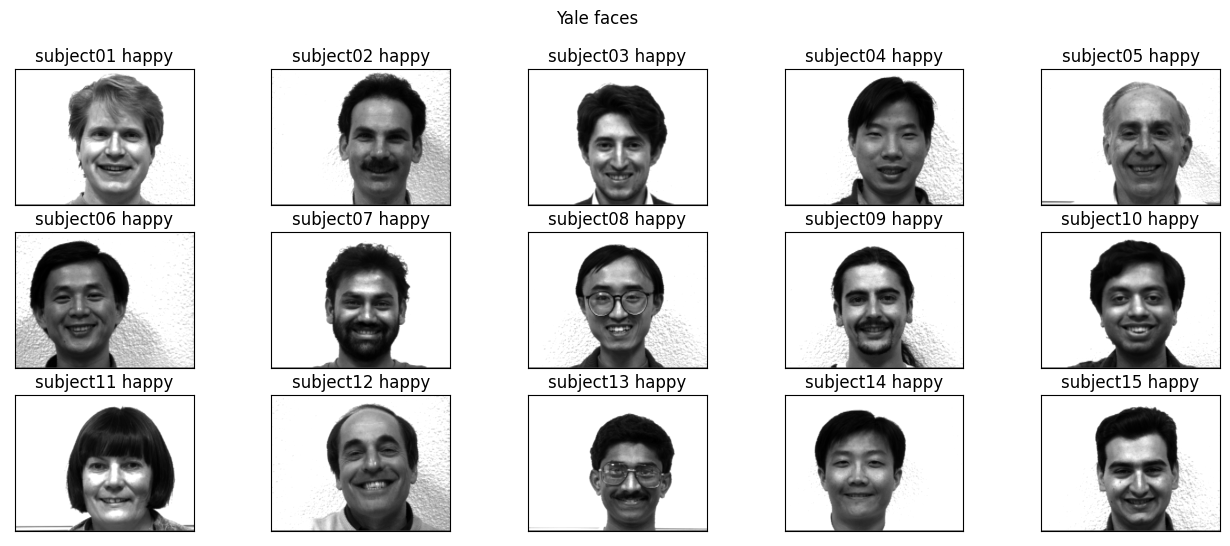

In [8]:
fig = plt.figure(figsize=(16, 6))
plt.suptitle('Yale faces')
for i in ['0'+str(numbr) for numbr in range(1, 10)]+[str(numbr) for numbr in range(10, 16)]:
    ax = fig.add_subplot(3, 5, int(i), xticks=[], yticks=[])
    ax.imshow(Image.open(f'./data/subject{i}.happy.pgm'), cmap='gray')
    plt.title(f'subject{i} happy');

Видно, что лица не всегда в центре изображения

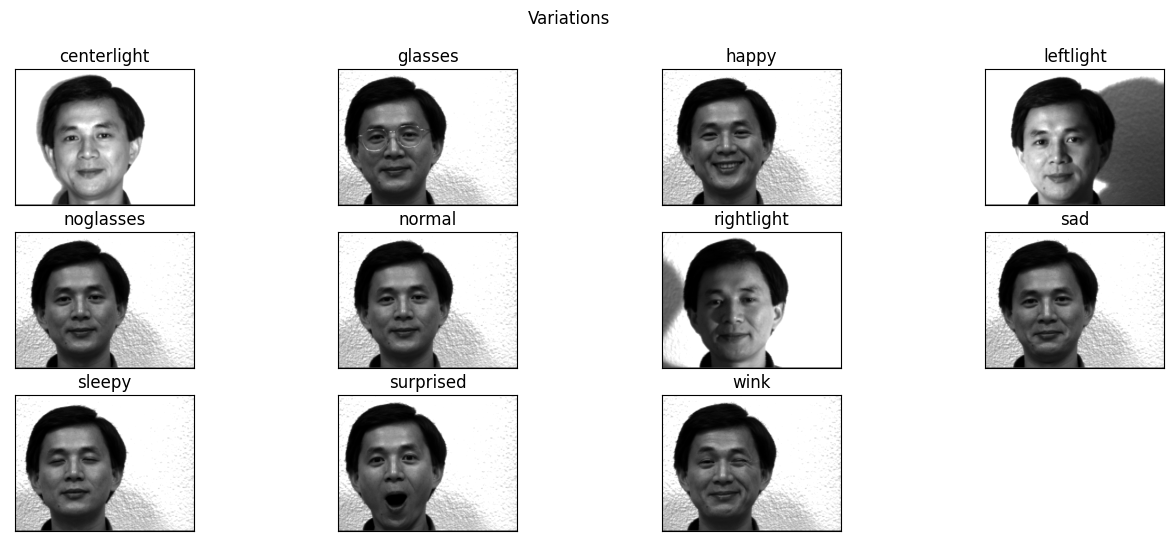

In [11]:
l = glob.glob('./data/subject06'.zfill(2)+"*")
fig = plt.figure(figsize=(16, 6))
plt.suptitle('Variations')
for i in range(len(l)):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(Image.open(l[i]), cmap='gray')
    plt.title(l[i][17:-4]);

# Распознавание лица с помощью каскада Хаара, обрезка изображений на основе результата

Единичный пример

In [42]:
name='./data/subject01.glasses.pgm'

In [43]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
image = cv2.imread(name)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(image, 1.2, 4)
if len(faces) == 1:
    for index, (x, y, w, h) in enumerate(faces):
        face = image[y:y+w, x:x+h]
        cv2.imwrite(f'./datacropped{name[6:-4]}.jpg', face)

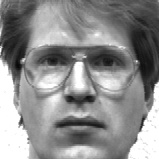

In [45]:
Image.open('./datacropped/subject01.glasses.jpg')

Обработка всего датасета

In [46]:
def crop(name):
    image = cv2.imread(name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(image, 1.2, 4) # распознаем лицо
    if len(faces) == 1:
        for index, (x, y, w, h) in enumerate(faces):
            face = image[y:y+w, x:x+h] # обрезаем изображение по контуру лица
            cv2.imwrite(f'./datacropped{name[6:-4]}.jpg', face) # записываем в новый файл результат
    else:
        print(f'error on processing {name} !')

In [53]:
# чтение изображений
imgs1 = []
for i in range(1, 16):
    filelist = glob.glob('./data/subject'+str(i).zfill(2)+"*")
    for fname in filelist:
        crop(fname)
        img = Image.open(f'./datacropped{fname[6:-4]}.jpg')
        imgs1.append(img)

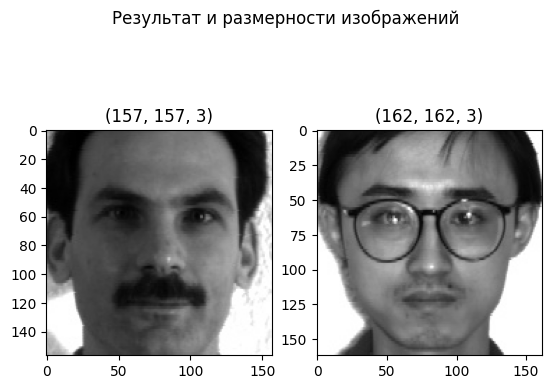

In [133]:
plt.suptitle('Результат и размерности изображений')
plt.subplot(1, 2, 1)
plt.imshow(imgs1[17])
plt.title(np.array(imgs1[17]).shape)
plt.subplot(1, 2, 2)
plt.imshow(imgs1[77])
plt.title(np.array(imgs1[77]).shape);

Изображения различаются по длине и ширине, необходимо это исправить

# Преобразование размера изображений

Сделаем изображения единой размерности

In [54]:
# берем среднее
shape1 = int(np.mean([np.array(i).shape[0] for i in imgs1]))
shape2 = int(np.mean([np.array(i).shape[1] for i in imgs1]))
imgs = [i.resize((shape1, shape1)) for i in imgs1]

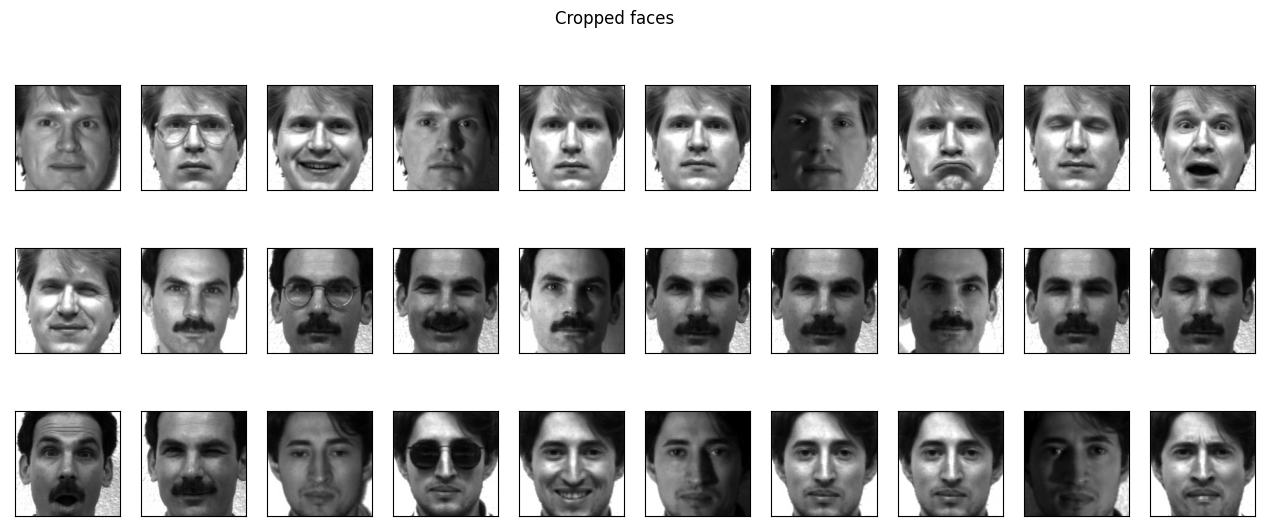

In [56]:
fig = plt.figure(figsize=(16, 6))
plt.suptitle('Cropped faces')
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(imgs[i], cmap='gray')

# Численое представление датасета

In [57]:
data = np.array([np.array(i, dtype=float).flatten() for i in imgs])

In [58]:
num = len(data)
num

165

In [64]:
imgss = np.array([np.array(i) for i in imgs])

In [65]:
# все изображения одного размера
np.std([i.shape[0] for i in imgss]), np.std([i.shape[1] for i in imgss]), np.std([i.shape[2] for i in imgss])

(0.0, 0.0, 0.0)

In [131]:
np.mean([i.shape[0] for i in imgss]), np.mean([i.shape[1] for i in imgss]), np.mean([i.shape[2] for i in imgss])

(152.0, 152.0, 3.0)

# Нормализация датасета

Нормализация датасета путем вычитания среднего вектора

In [66]:
mean_vector = np.mean(data, axis=0)
da = np.ndarray(shape=(len(data), shape1**2*3))

for i in range(len(data)):
    da[i] = np.subtract(data[i], mean_vector)

Интересно посмотреть на то, как выглядит "среднее" по выборке лицо

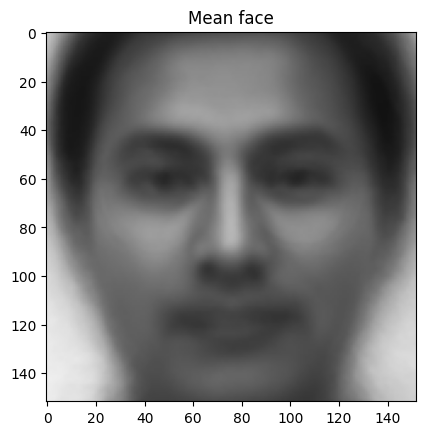

In [67]:
plt.imshow(mean_vector.reshape((shape1, shape1, 3)).astype(np.uint8), cmap='gray')
plt.title('Mean face');

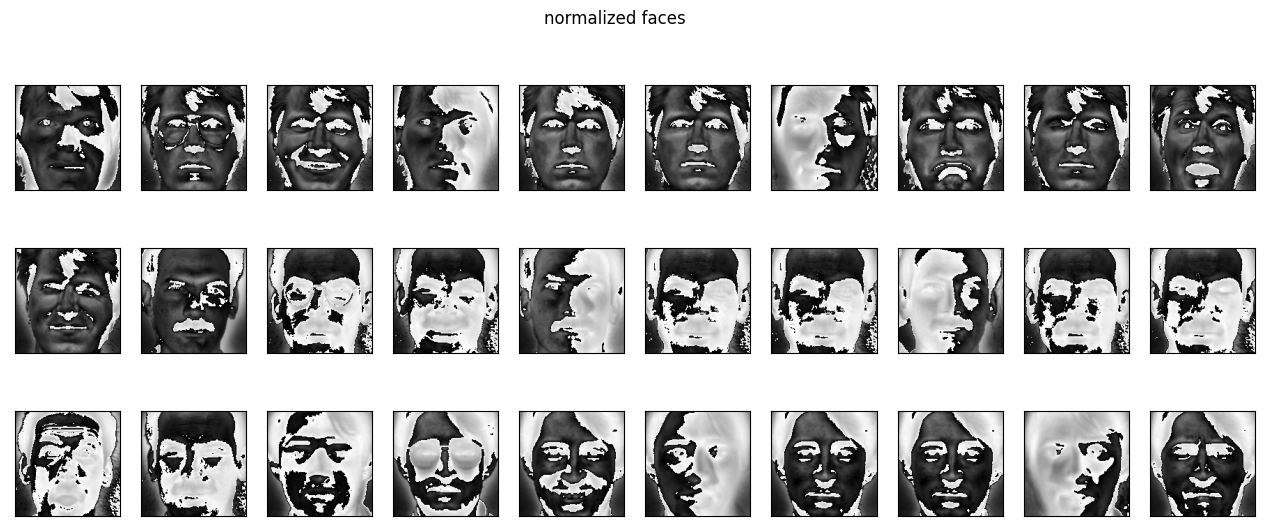

In [68]:
fig = plt.figure(figsize=(16, 6))
plt.suptitle('normalized faces')
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(da[i].reshape((shape1, shape1, 3)).astype(np.uint8), cmap='gray')

# Выбор признаков методом главных компонент

In [69]:
pca = decomposition.PCA(n_components=40, whiten=True).fit(da)

In [70]:
X = pca.transform(da)

# Тестовая и обучающая выборки

In [71]:
Y = np.sort(list(np.arange(1, 16))*11)

In [72]:
ids = np.random.choice(np.arange(num), size=int(num*0.2), replace=False)
X_test_pca, X_train_pca = X[ids], X[np.array(list(set(np.arange(165)) - set(ids)))]
y_test, y_train = Y[ids], Y[np.array(list(set(np.arange(165)) - set(ids)))]

# Обучение моделей машинного обучения

## Оптимизация параметров для метода опорных векторов SVM с помощью поиска по сетке GridSearchCV

In [73]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
grid.fit(X_train_pca, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.074 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.074 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.115 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.077 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.077 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.074 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.074 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.115 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.154 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.077 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.074 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [74]:
grid.best_params_, grid.best_estimator_

({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, SVC(C=10, gamma=0.001))

In [75]:
clf = svm.SVC(C=10, gamma=0.001, kernel='rbf')
clf.fit(X_train_pca, y_train)

SVC(C=10, gamma=0.001)

## Оценка качества работы модели

In [139]:
y_pred = clf.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           3       1.00      0.50      0.67         4
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         2
           6       0.33      1.00      0.50         1
           7       1.00      1.00      1.00         1
           8       0.67      1.00      0.80         2
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         3
          11       1.00      0.67      0.80         3
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         2

    accuracy                           0.91        33
   macro avg       0.92      0.94      0.91        33
weighted avg       0.96      0.91      0.91        33



In [82]:
print(f"Для метода опорных векторов\nAccuracy = {np.round(clf.score(X_test_pca, y_test), 4)}")
print(f"Precision = {np.round(metrics.precision_score(y_test, y_pred, average='weighted'), 4)}")
print(f"Recall = {np.round(metrics.recall_score(y_test, y_pred, average='weighted'), 4)}")
print(f"F1-score = {np.round(metrics.f1_score(y_test, y_pred, average='weighted'), 4)}")

Для метода опорных векторов
Accuracy = 0.9091
Precision = 0.9596
Recall = 0.9091
F1-score = 0.9141


In [85]:
kf = KFold(n_splits=5 ,shuffle=True, random_state=15)
cv_results = cross_val_score(clf, X, Y, cv = kf, scoring = 'accuracy')

print("Кросс-валидация: ", np.round(cv_results, 4))
print("Среднее по кросс-валидации: ", np.round(cv_results.mean(), 4))
print("Дисперсия по кросс-валидации: ", np.round(cv_results.std(), 4))

Кросс-валидация:  [0.7879 0.8485 0.8485 0.9394 0.9394]
Среднее по кросс-валидации:  0.8727
Дисперсия по кросс-валидации:  0.0588


Красным отмечены ошибки

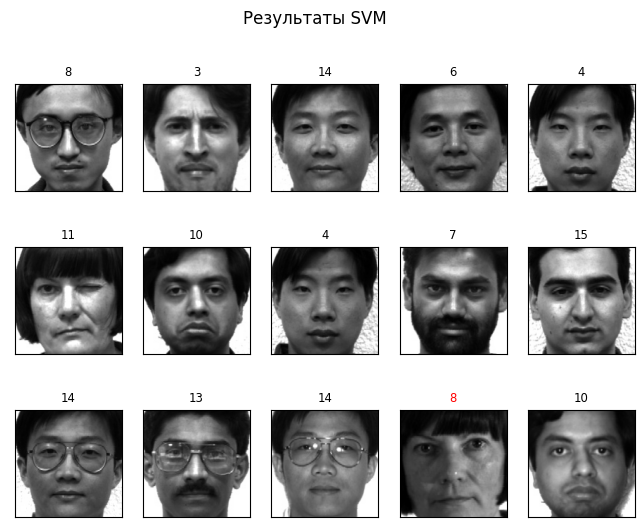

In [120]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle('Результаты SVM')
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(data[ids[i]].reshape((shape1, shape1, 3)).astype(np.uint8),
              cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i, np.newaxis])[0]
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

## Оптимизация параметра n_neighbors для метода К ближайших соседей KNN с помощью поиска по сетке GridSearchCV

In [98]:
param_grid1 = {'n_neighbors': list(range(1, 31))}

grid1 = GridSearchCV(KNeighborsClassifier(), param_grid1, refit = True, verbose = 3)
grid1.fit(X_train_pca, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.815 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.630 total time=   0.0s
[CV 3/5] END .....................n_neighbors=1;, score=0.538 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.808 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.808 total time=   0.0s
[CV 1/5] END .....................n_neighbors=2;, score=0.778 total time=   0.0s
[CV 2/5] END .....................n_neighbors=2;, score=0.741 total time=   0.0s
[CV 3/5] END .....................n_neighbors=2;, score=0.692 total time=   0.0s
[CV 4/5] END .....................n_neighbors=2;, score=0.808 total time=   0.0s
[CV 5/5] END .....................n_neighbors=2;, score=0.654 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.741 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=3)

In [99]:
grid1.best_params_, grid1.best_estimator_

({'n_neighbors': 3}, KNeighborsClassifier(n_neighbors=3))

In [100]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=3)

## Оценка качества работы модели

In [113]:
y_predknn = knn.predict(X_test_pca)
print('\t\tОтчет для метода К ближайших соседей\n', metrics.classification_report(y_test, y_predknn, zero_division=0))

		Отчет для метода К ближайших соседей
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.75      0.75      0.75         4
           4       1.00      0.80      0.89         5
           5       0.67      1.00      0.80         2
           6       0.20      1.00      0.33         1
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         2
           9       1.00      1.00      1.00         1
          10       1.00      0.67      0.80         3
          11       1.00      0.67      0.80         3
          12       1.00      0.20      0.33         5
          13       0.50      1.00      0.67         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         2

    accuracy                           0.70        33
   macro avg       0.67      0.67      0

In [104]:
print(f"Для метода опорных векторов\nAccuracy = {np.round(knn.score(X_test_pca, y_test), 4)}")
print(f"F1-score = {np.round(metrics.f1_score(y_test, y_predknn, average='weighted'), 4)}")

Для метода опорных векторов
Accuracy = 0.697
F1-score = 0.7125


In [105]:
cv_resultsknn = cross_val_score(knn, X, Y, cv = kf, scoring = 'accuracy')

print("Кросс-валидация: ", np.round(cv_resultsknn, 4))
print("Среднее по кросс-валидации: ", np.round(cv_resultsknn.mean(), 4))
print("Дисперсия по кросс-валидации: ", np.round(cv_resultsknn.std(), 4))

Кросс-валидация:  [0.5758 0.8485 0.6364 0.7879 0.8182]
Среднее по кросс-валидации:  0.7333
Дисперсия по кросс-валидации:  0.1074


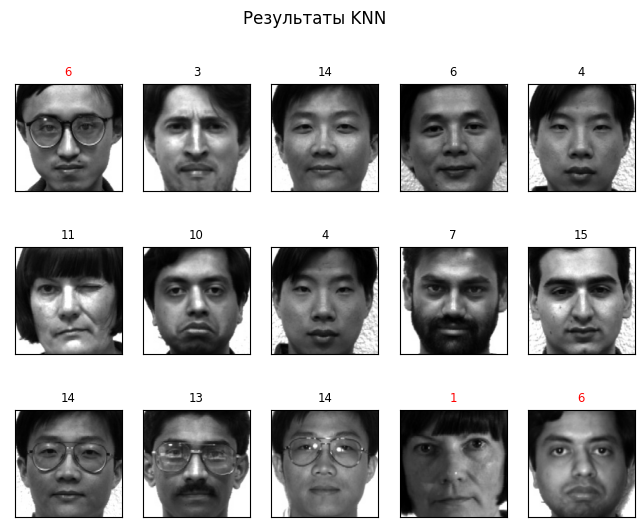

In [119]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle('Результаты KNN')
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(data[ids[i]].reshape((shape1, shape1, 3)).astype(np.uint8),
              cmap=plt.cm.bone)
    y_pred = knn.predict(X_test_pca[i, np.newaxis])[0]
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

## Оптимизация параметра n_neighbors для метода К ближайших соседей KNN с помощью поиска по сетке GridSearchCV

In [109]:
param_grid2 = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid2 = GridSearchCV(LogisticRegression(), param_grid2, refit = True, verbose = 3)
grid2.fit(X_train_pca, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...........................C=0.001;, score=0.148 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.111 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.231 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.154 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.154 total time=   0.0s
[CV 1/5] END ............................C=0.01;, score=0.926 total time=   0.0s
[CV 2/5] END ............................C=0.01;, score=0.852 total time=   0.0s
[CV 3/5] END ............................C=0.01;, score=0.769 total time=   0.0s
[CV 4/5] END ............................C=0.01;, score=0.769 total time=   0.0s
[CV 5/5] END ............................C=0.01;, score=0.769 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.963 total time=   0.0s
[CV 2/5] END .............................C=0.1;,

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, verbose=3)

In [110]:
grid2.best_params_, grid2.best_estimator_

({'C': 0.1}, LogisticRegression(C=0.1))

In [111]:
logreg = LogisticRegression(C=0.1)
logreg.fit(X_train_pca, y_train)

LogisticRegression(C=0.1)

## Оценка качества работы модели

In [115]:
y_predlogreg = logreg.predict(X_test_pca)
print('\t\tОтчет для метода логистической регрессии\n', metrics.classification_report(y_test, y_predlogreg))

		Отчет для метода логистической регрессии
               precision    recall  f1-score   support

           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         2
           6       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         2

    accuracy                           0.97        33
   macro avg       0.96      0.98      0.96        33
weighted avg       0.98      0.97      0.97        33



In [116]:
print(f"Для метода опорных векторов\nAccuracy = {np.round(logreg.score(X_test_pca, y_test), 4)}")
print(f"Precision = {np.round(metrics.precision_score(y_test, y_predlogreg, average='weighted'), 4)}")
print(f"Recall = {np.round(metrics.recall_score(y_test, y_predlogreg, average='weighted'), 4)}")
print(f"F1-score = {np.round(metrics.f1_score(y_test, y_predlogreg, average='weighted'), 4)}")

Для метода опорных векторов
Accuracy = 0.9697
Precision = 0.9848
Recall = 0.9697
F1-score = 0.9726


In [117]:
cv_resultslogreg = cross_val_score(logreg, X, Y, cv = kf, scoring = 'accuracy')

print("Кросс-валидация: ", np.round(cv_resultslogreg, 4))
print("Среднее по кросс-валидации: ", np.round(cv_resultslogreg.mean(), 4))
print("Дисперсия по кросс-валидации: ", np.round(cv_resultslogreg.std(), 4))

Кросс-валидация:  [0.7879 0.9091 0.9394 0.9697 0.9091]
Среднее по кросс-валидации:  0.903
Дисперсия по кросс-валидации:  0.0618


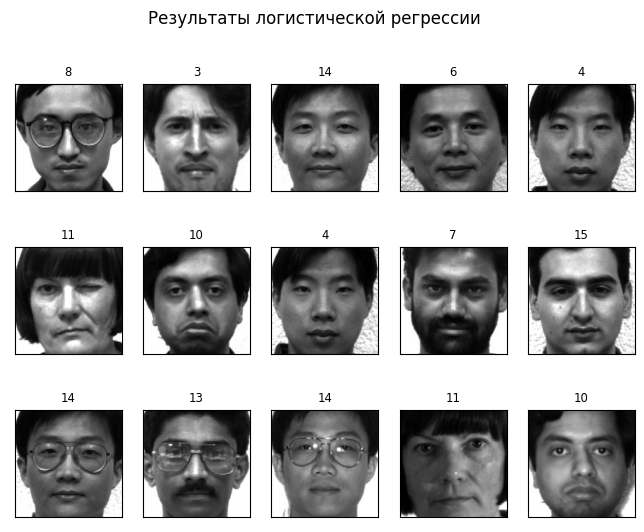

In [121]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle('Результаты логистической регрессии')
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(data[ids[i]].reshape((shape1, shape1, 3)).astype(np.uint8),
              cmap=plt.cm.bone)
    y_pred = logreg.predict(X_test_pca[i, np.newaxis])[0]
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

In [146]:
len(y_predlogreg[y_predlogreg != y_test]), len(y_predlogreg[y_predlogreg == y_test])

(1, 32)

In [142]:
res = pd.DataFrame(np.array([[np.round(knn.score(X_test_pca, y_test), 4), np.round(metrics.f1_score(y_test, y_predknn, average='weighted'), 4), np.round(cv_resultsknn.mean(), 4)], [np.round(clf.score(X_test_pca, y_test), 4), np.round(metrics.f1_score(y_test, y_pred, average='weighted'), 4), np.round(cv_results.mean(), 4)], [np.round(logreg.score(X_test_pca, y_test), 4), np.round(metrics.f1_score(y_test, y_predlogreg, average='weighted'), 4), np.round(cv_resultslogreg.mean(), 4)]]),columns=['Accuracy', 'F1-score', 'Среднее accuracy по кросс-валидации'], index=['KNN', 'SVM', 'Logistic regression'])

In [143]:
res

,Accuracy,F1-score,Среднее accuracy по кросс-валидации
KNN,0.6970,0.7125,0.7333
SVM,0.9091,0.9141,0.8727
Logistic regression,0.9697,0.9726,0.9030


**Налиучшей моделью оказалась модель логистической регрессии с параметром C = 0.1**

**Результаты**  
Для подготовки данных к успешному классификационному моделированию была проведена поэтапная предобработка данных. Для обнаружения лица на фотографии был использован каскад Хаара, по его результатам изображения обрезались по квадрату контура лица. Затем изображения приводились к единой размерности, определяемой по среднему значению. Фото были приведены в векторную форму, полученный датасет был нормализован путем вычитания среднего вектора. Наиболее информативные признаки были выбраны с использованием метода главных компонент. По полученным данным было оценено несколько моделей классификации (метод опорных векторов, метод К ближайших соседей, логистическая регрессия). Лучшая модель, построенная по предобработанным данным показала высокое среднее по кросс-валидации значение метрики accuracy (равное 0,903), что говорит о высокой точности построенной модели классификации. Так по тестовой выборке модель неверно идентифицировала личность только в одном случае из 33.  
Процесс анализа и обработки данных был основан на особенностях датасета Yale Face Database, работа позволила определить один из эффективных, судя по полученным метрикам, способов решения задачи преобразования данных в целях идентификации личности по изображению в условиях следующих меняющихся естественных факторов: выражение лица человека, наличие очков, положение источника света. Такой подход может быть применим и к другим изображениям, потенциально обладающим такими особенностями, а также имеет потенциал в развитии в сценариях работы с большим количеством усложняющих факторов, которые, к примеру, могут привести к ложному обнаружению лица на фотографии (пестрый фон) или необнаружению лица в принципе (низкое разрешение).  